In [1]:
import pandas as pd
import numpy as np
import calendar
from datetime import datetime as dt
import ast
import shapefile
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from matplotlib.patches import Polygon as polyg
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def get_KDE(contin, lambda_ = 0.25, min_ = True):
    '''gauss kernel density estimate to check distribution of continuous variables'''
    max_ = contin.max()
    if min_ == True:
        density = gaussian_kde(contin)
        xs = np.linspace(0, max_, 1000)
    elif min_:
        density = gaussian_kde(contin)
        xs = np.linspace(min_, max_, 1000) 
    else:
        density = gaussian_kde(contin)
        xs = np.linspace(contin.min(), max_, 1000)         
    density.covariance_factor = lambda : lambda_
    density._compute_covariance()
    return xs, density(xs)

In [3]:
# acc = pd.read_csv('assets/2017_clean.csv')
# qgis = pd.read_csv('assets/QGIS_coords.csv')
# acc = pd.concat([acc, qgis], axis = 1)
# del qgis
# acc.head(2)

### Date-related

In [4]:
# acc['dt'] = [dt.strptime(x, '%m/%d/%Y') for x in acc['date']]
# acc['monthday'] = [x.day for x in acc['dt']]
# acc['weekday'] = [calendar.day_name[x.weekday()] for x in acc['dt']]
# acc['ordinal'] = [x.toordinal() for x in acc['dt']]
# acc['month'] = [calendar.month_name[x.month] for x in acc['dt']]

### Time-related

In [5]:
# acc['time'] = acc['time'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60.)
# acc['ordinal_dec'] = acc['ordinal'] + acc['time']/24.

### Borough

In [6]:
# len(acc[acc['borough'].isnull()])

In [7]:
# start = dt.now()
# print(start)

# ## fill in missing boroughs using borough shapefile and transformed coordinates
# reader = shapefile.Reader("assets/nybb_18a/nybb.shp")
# fields = [field[0] for field in reader.fields[1:]]

# count = 0
# for i in list(acc[acc['borough'].isnull()].index):
#     point = Point(acc.loc[i, 'X'], acc.loc[i, 'Y'])
#     for feature in reader.shapeRecords():
#         geom = feature.shape.__geo_interface__
#         boro = dict(zip(fields, feature.record))['BoroName'].upper()
#         for lil_polygon in geom['coordinates']:
#             polygon = Polygon(lil_polygon[0]) 
#             if polygon.contains(point):
#                 acc.loc[i, 'borough'] = boro
#                 break
#     if count%10000 == 0:
#         print(count, end = '')
#     elif count%1000 == 0:
#         print('.', end = '')
#     count += 1

# end = dt.now()
# print('\n', end - start)
# print(len(acc[acc['borough'].isnull()])/len(acc))

In [8]:
# len(acc[acc['borough'].isnull()])

In [9]:
# acc.to_csv('assets/2017_final.csv', index = False)

In [10]:
acc = pd.read_csv('assets/2017_final.csv')

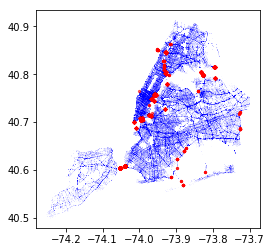

In [11]:
plt.figure(figsize = (4, 4))
lil_df = acc[acc['borough'].isnull()]

plt.scatter(acc['lon'], acc['lat'], color = 'blue', s = 0.0001)
plt.scatter(lil_df['lon'], lil_df['lat'], color = 'red', s = 5, alpha = 0.6)

plt.show();

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Seems like all the rows that didn't get a borough assignment using the shapefile polygons are located on bridges/in tunnels/in between boroughs somehow.  It's a small minority of total observation count, so we'll just keep tabs on them in each subset below.

## Cyclists

In [12]:
cyc = acc[(acc['cyclist injured'] != 0) | (acc['cyclist killed'] != 0)]

13


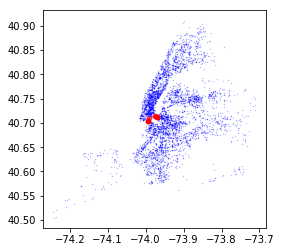

In [13]:
plt.figure(figsize = (4, 4))
lil_df = cyc[cyc['borough'].isnull()]

plt.scatter(cyc['lon'], cyc['lat'], color = 'blue', s = 0.1, alpha = 0.4)
plt.scatter(lil_df['lon'], lil_df['lat'], color = 'red', s = 20, alpha = 0.6)

print(len(cyc[cyc['borough'].isnull()]))

plt.show();

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Thirteen cyclist-related observations have no borough listed; they appear to have occured on bridges between Manhattan and Brooklyn.

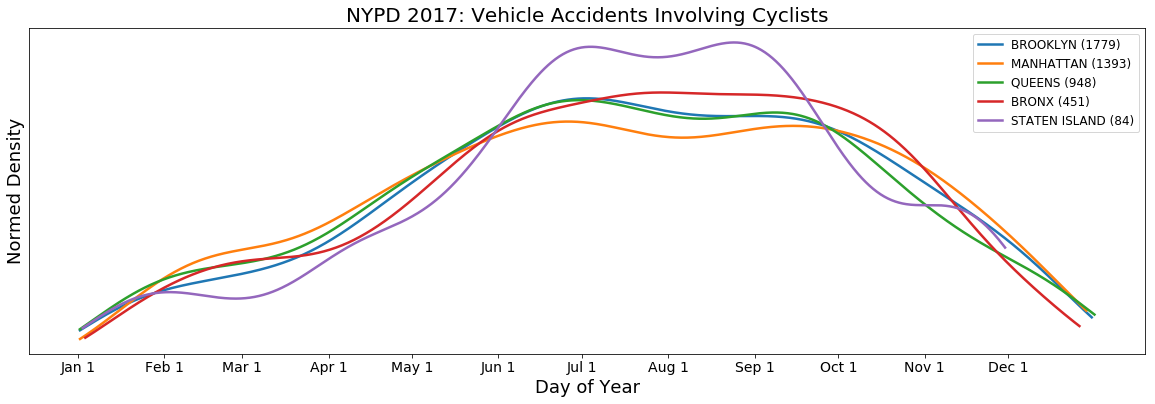

In [14]:
fig, ax = plt.subplots(figsize = (20, 6))

for boro in list(cyc['borough'].value_counts().index):
    lil_cyc = cyc[cyc['borough'] == boro]
    xs, density_xs = get_KDE(lil_cyc['ordinal_dec'], lambda_ = 0.25, min_ = False)
    cyclet = ax.plot(xs, density_xs, linewidth = 2.5, label = '{} ({})'.format(boro, len(lil_cyc)))

## get ordinal for first day of each month in 2017
firstofmonth = []
for month in range(1, 13):
    result = dt.strptime('2017-{}-01'.format(month), '%Y-%m-%d')#.date()
    firstofmonth.append(result.toordinal())
    
plt.title('NYPD 2017: Vehicle Accidents Involving Cyclists', fontsize = 20)
xticks = ['Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'May 1', 'Jun 1', 'Jul 1', 'Aug 1', 'Sep 1', 'Oct 1', 'Nov 1', 'Dec 1']
plt.xticks(firstofmonth, xticks, fontsize = 14)
plt.xlabel('Day of Year', fontsize = 18)
plt.yticks([])
plt.ylabel('Normed Density', fontsize = 18)
plt.legend(loc = 'best', fontsize = 12)
plt.grid(False)
plt.show();

In [15]:
# tmp = gpd.GeoDataFrame.from_file('assets/nybb_18a/nybb.shp')

# tmpWGS84 = tmp.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

# tmpWGS84.to_file('assets/nybb_18a/WGS84.shp')

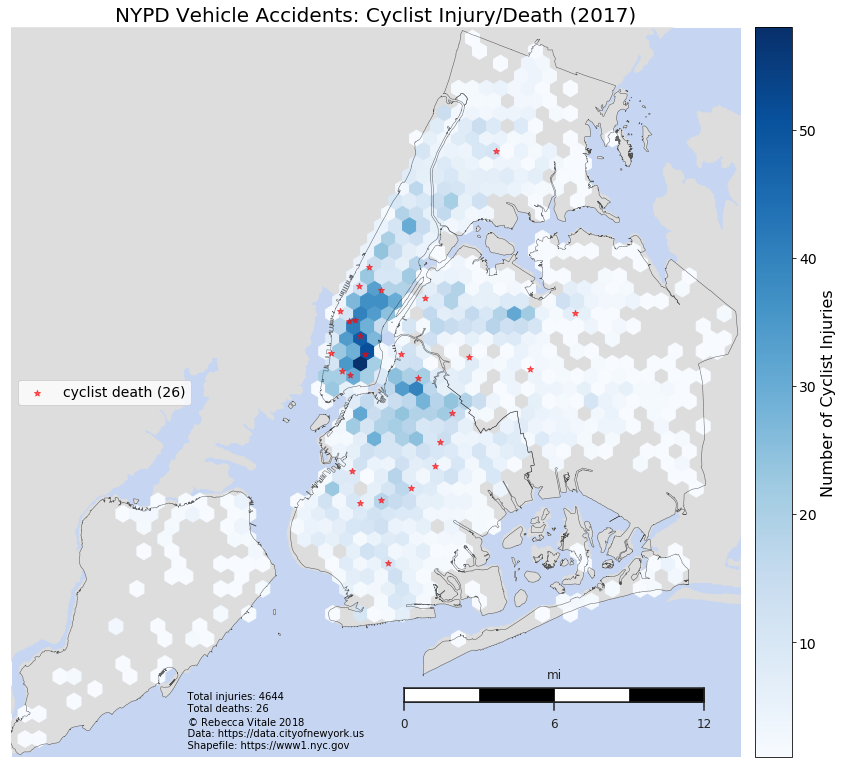

In [16]:
fig, ax = plt.subplots(figsize = (14, 14))
fig.patch.set_facecolor('white') ## so title background not transparent
plt.title('NYPD Vehicle Accidents: Cyclist Injury/Death (2017)', fontsize = 20)

m = Basemap(
    height = 4.7E4,
    width = 4.7E4,
    resolution = 'f',
    projection = 'aea',
    lat_1 = acc['lat'].min(),
    lat_2 = acc['lat'].max(),
    lat_0 = (acc['lat'].min() + acc['lat'].max())/2.,
    lon_0 = (acc['lon'].min() + acc['lon'].max())/2.
)

water_color = '#c6d6f2'
m.fillcontinents(color = '#dddddd', lake_color = water_color, zorder = 2)
m.drawmapboundary(fill_color = water_color, color = 'white', zorder = 1)

m.readshapefile(
    'assets/nybb_18a/WGS84',
    'lil_place',
    drawbounds = True,
    color = '#cccccc',
    zorder = 3
)

m.scatter(
    cyc.loc[cyc['cyclist killed'] != 0, 'lon'].values,
    cyc.loc[cyc['cyclist killed'] != 0, 'lat'].values,
    latlon = True,
    zorder = 6,
    color = 'red',
    alpha = 0.6,
    s = 40,
    marker = '*',
    label = 'cyclist death ({})'.format(len(cyc[cyc['cyclist killed'] != 0]))
)

patches = []
for info, shape in zip(m.lil_place_info, m.lil_place):
    patches.append( polyg(np.array(shape), True) )

ax.add_collection(
    PatchCollection(
        patches,
        facecolor = '#dddddd',
        zorder = 4
    )
)

## convert latlon to basemap coords
cyc['bm_coord'] = [m(x, y) for x, y in zip(cyc['lon'], cyc['lat'])]

m.hexbin(
    x = cyc.loc[cyc['cyclist injured'] != 0, 'bm_coord'].apply(lambda x: x[0]),
    y = cyc.loc[cyc['cyclist injured'] != 0, 'bm_coord'].apply(lambda x: x[1]),
#     C = C,
    gridsize = 50,
    mincnt = 1,
    cmap = 'Blues',
#     reduce_C_function = reduce_C_function,
#     norm = norm,
    zorder = 5
)

for info, shape in zip(m.lil_place_info, m.lil_place):
    x, y = zip(*shape)
    m.plot(
        x,
        y,
        color = 'k',
        alpha = 0.6,
        zorder = 5,
        linewidth = 0.5
    )

cb = m.colorbar(location = 'right', format = '%d')
cb.set_label(label = 'Number of Cyclist Injuries', fontsize = 16)
cb.ax.tick_params(labelsize = 14)
# cb.set_ticks([0, 50, 150, 200])
# cb.set_ticklabels([1, 5, 10, 15, 20, 25, 30])

total_area = sum([Polygon(xy).area/1000000 for xy in m.lil_place])

smallprint = ax.text(
    0.225,
    0.01,
    '\
    Total injuries: {}\n\
    Total deaths: {}\n\
    $\copyright$ Rebecca Vitale 2018\n\
    Data: https://data.cityofnewyork.us\n\
    Shapefile: https://www1.nyc.gov'.format(
        len(cyc[cyc['cyclist injured'] != 0]), 
        len(cyc[cyc['cyclist killed'] != 0])),
    ha = 'left',
    va = 'bottom',
    size = 10,
    color = 'k',
    transform = ax.transAxes,
    zorder = 6
)

scale_coord = (35000, 4000)
scale_where = m(scale_coord[0], scale_coord[1], inverse = True)
m.drawmapscale(
    scale_where[0],
    scale_where[1],
    scale_where[0],
    scale_where[1],
    12,
    fontsize = 12,
    barstyle = 'fancy',
    zorder = 6,
    fontcolor = '#222222',
    units = 'mi'
)

plt.legend(loc = 'center left', fontsize = 14)
plt.show();

## Pedestrians

In [17]:
ped = acc[(acc['pedestrians injured'] != 0) | (acc['pedestrians killed'] != 0)]

12


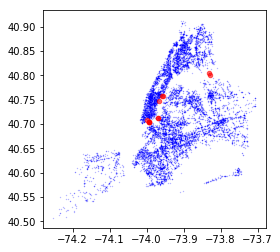

In [18]:
plt.figure(figsize = (4, 4))
lil_df = ped[ped['borough'].isnull()]

plt.scatter(ped['lon'], ped['lat'], color = 'blue', s = 0.1, alpha = 0.4)
plt.scatter(lil_df['lon'], lil_df['lat'], color = 'red', s = 20, alpha = 0.6)

print(len(ped[ped['borough'].isnull()]))

plt.show();

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Twelve pedestrian-related observations have no borough listed; they appear to have occured on bridges between Manhattan/Brooklyn, Manhattan/Queens, and Queens/Bronx.

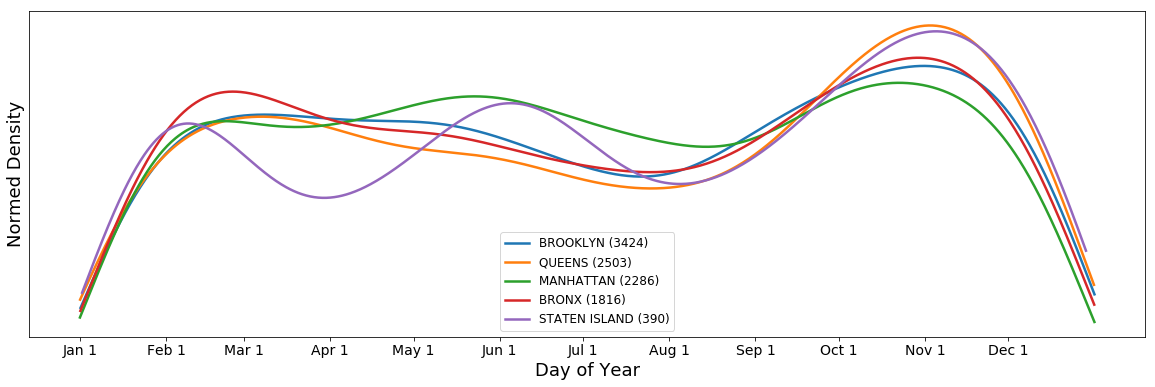

In [19]:
fig, ax = plt.subplots(figsize = (20, 6))

for boro in list(ped['borough'].value_counts().index):
    lil_ped = ped[ped['borough'] == boro]
    xs, density_xs = get_KDE(lil_ped['ordinal_dec'], lambda_ = 0.25, min_ = False)
    pedlet = ax.plot(xs, density_xs, linewidth = 2.5, label = '{} ({})'.format(boro, len(lil_ped)))

## get ordinal for first day of each month in 2017
firstofmonth = []
for month in range(1, 13):
    result = dt.strptime('2017-{}-01'.format(month), '%Y-%m-%d')#.date()
    firstofmonth.append(result.toordinal())
    
plt.title('', fontsize = 18)
xticks = ['Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'May 1', 'Jun 1', 'Jul 1', 'Aug 1', 'Sep 1', 'Oct 1', 'Nov 1', 'Dec 1']
plt.xticks(firstofmonth, xticks, fontsize = 14)
plt.xlabel('Day of Year', fontsize = 18)
plt.yticks([])
plt.ylabel('Normed Density', fontsize = 18)
plt.legend(loc = 'best', fontsize = 12)
plt.grid(False)
plt.show();

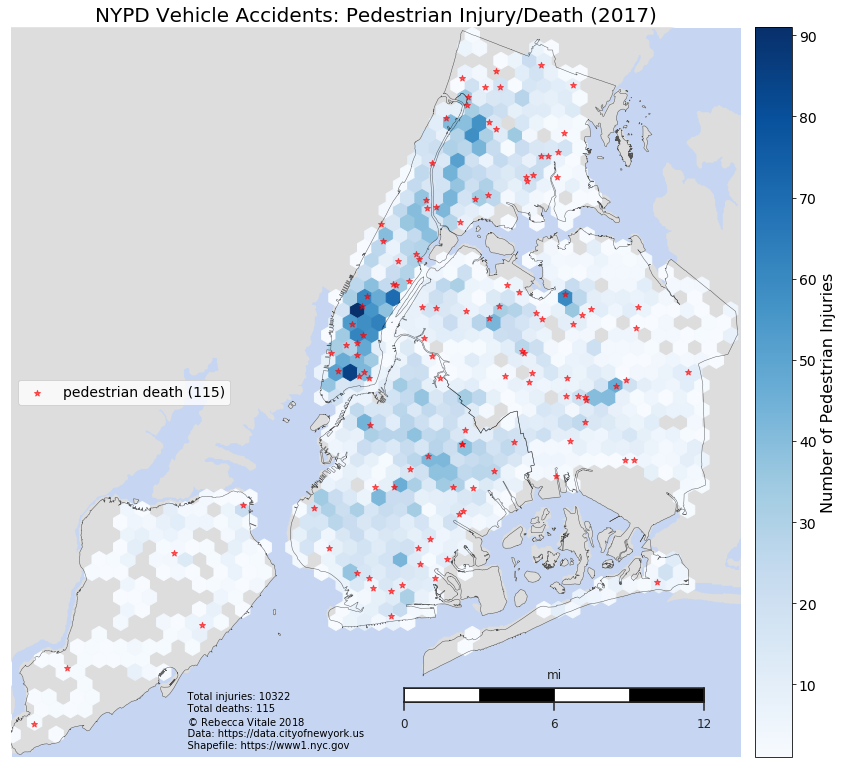

In [20]:
fig, ax = plt.subplots(figsize = (14, 14))
fig.patch.set_facecolor('white') ## so title background not transparent
plt.title('NYPD Vehicle Accidents: Pedestrian Injury/Death (2017)', fontsize = 20)

m = Basemap(
    height = 4.7E4,
    width = 4.7E4,
    resolution = 'f',
    projection = 'aea',
    lat_1 = acc['lat'].min(),
    lat_2 = acc['lat'].max(),
    lat_0 = (acc['lat'].min() + acc['lat'].max())/2.,
    lon_0 = (acc['lon'].min() + acc['lon'].max())/2.
)

water_color = '#c6d6f2'
m.fillcontinents(color = '#dddddd', lake_color = water_color, zorder = 2)
m.drawmapboundary(fill_color = water_color, color = 'white', zorder = 1)

m.readshapefile(
    'assets/nybb_18a/WGS84',
    'lil_place',
    drawbounds = True,
    color = '#cccccc',
    zorder = 3
)

m.scatter(
    ped.loc[ped['pedestrians killed'] != 0, 'lon'].values,
    ped.loc[ped['pedestrians killed'] != 0, 'lat'].values,
    latlon = True,
    zorder = 6,
    color = 'red',
    alpha = 0.6,
    s = 40,
    marker = '*',
    label = 'pedestrian death ({})'.format(len(ped[ped['pedestrians killed'] != 0]))
)

patches = []
for info, shape in zip(m.lil_place_info, m.lil_place):
    patches.append( polyg(np.array(shape), True) )

ax.add_collection(
    PatchCollection(
        patches,
        facecolor = '#dddddd',
        zorder = 4
    )
)

## convert latlon to basemap coords
ped['bm_coord'] = [m(x, y) for x, y in zip(ped['lon'], ped['lat'])]

m.hexbin(
    x = ped.loc[ped['pedestrians injured'] != 0, 'bm_coord'].apply(lambda x: x[0]),
    y = ped.loc[ped['pedestrians injured'] != 0, 'bm_coord'].apply(lambda x: x[1]),
#     C = C,
    gridsize = 50,
    mincnt = 1,
    cmap = 'Blues',
#     reduce_C_function = reduce_C_function,
#     norm = norm,
    zorder = 5
)

for info, shape in zip(m.lil_place_info, m.lil_place):
    x, y = zip(*shape)
    m.plot(
        x,
        y,
        color = 'k',
        alpha = 0.6,
        zorder = 5,
        linewidth = 0.5
    )

cb = m.colorbar(location = 'right', format = '%d')
cb.set_label(label = 'Number of Pedestrian Injuries', fontsize = 16)
cb.ax.tick_params(labelsize = 14)
# cb.set_ticks([0, 50, 150, 200])
# cb.set_ticklabels([1, 5, 10, 15, 20, 25, 30])

total_area = sum([Polygon(xy).area/1000000 for xy in m.lil_place])

smallprint = ax.text(
    0.225,
    0.01,
    '\
    Total injuries: {}\n\
    Total deaths: {}\n\
    $\copyright$ Rebecca Vitale 2018\n\
    Data: https://data.cityofnewyork.us\n\
    Shapefile: https://www1.nyc.gov'.format(
        len(ped[ped['pedestrians injured'] != 0]), 
        len(ped[ped['pedestrians killed'] != 0])),
    ha = 'left',
    va = 'bottom',
    size = 10,
    color = 'k',
    transform = ax.transAxes,
    zorder = 6
)

scale_coord = (35000, 4000)
scale_where = m(scale_coord[0], scale_coord[1], inverse = True)
m.drawmapscale(
    scale_where[0],
    scale_where[1],
    scale_where[0],
    scale_where[1],
    12,
    fontsize = 12,
    barstyle = 'fancy',
    zorder = 6,
    fontcolor = '#222222',
    units = 'mi'
)

plt.legend(loc = 'center left', fontsize = 14)
plt.show();

## Motorists

In [21]:
motor = acc[(acc['motorist injured'] != 0) | (acc['motorist killed'] != 0)]

625


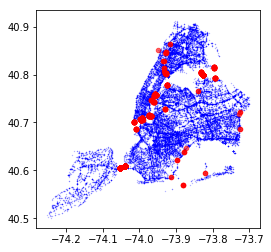

In [22]:
plt.figure(figsize = (4, 4))
lil_df = motor[motor['borough'].isnull()]

plt.scatter(motor['lon'], motor['lat'], color = 'blue', s = 0.1, alpha = 0.4)
plt.scatter(lil_df['lon'], lil_df['lat'], color = 'red', s = 20, alpha = 0.6)

print(len(motor[motor['borough'].isnull()]))

plt.show();

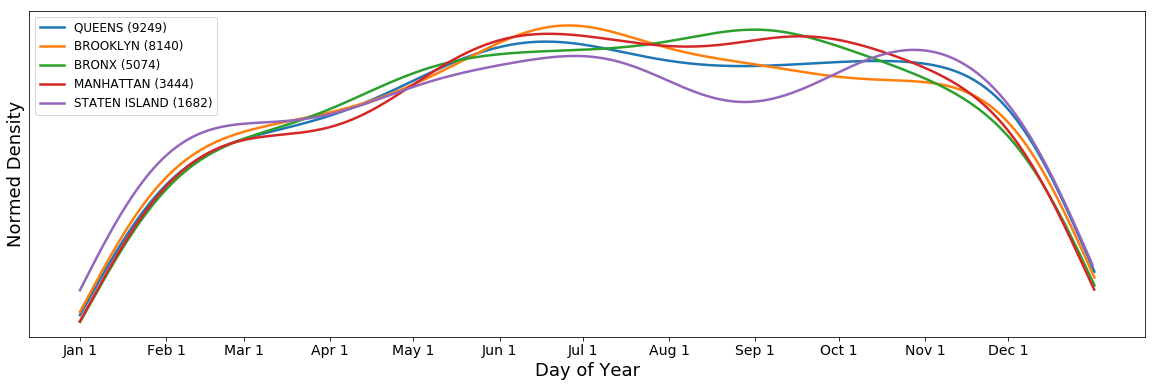

In [23]:
fig, ax = plt.subplots(figsize = (20, 6))

for boro in list(motor['borough'].value_counts().index):
    lil_motor = motor[motor['borough'] == boro]
    xs, density_xs = get_KDE(lil_motor['ordinal_dec'], lambda_ = 0.25, min_ = False)
    pedlet = ax.plot(xs, density_xs, linewidth = 2.5, label = '{} ({})'.format(boro, len(lil_motor)))

## get ordinal for first day of each month in 2017
firstofmonth = []
for month in range(1, 13):
    result = dt.strptime('2017-{}-01'.format(month), '%Y-%m-%d')#.date()
    firstofmonth.append(result.toordinal())
    
plt.title('', fontsize = 18)
xticks = ['Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'May 1', 'Jun 1', 'Jul 1', 'Aug 1', 'Sep 1', 'Oct 1', 'Nov 1', 'Dec 1']
plt.xticks(firstofmonth, xticks, fontsize = 14)
plt.xlabel('Day of Year', fontsize = 18)
plt.yticks([])
plt.ylabel('Normed Density', fontsize = 18)
plt.legend(loc = 'best', fontsize = 12)
plt.grid(False)
plt.show();

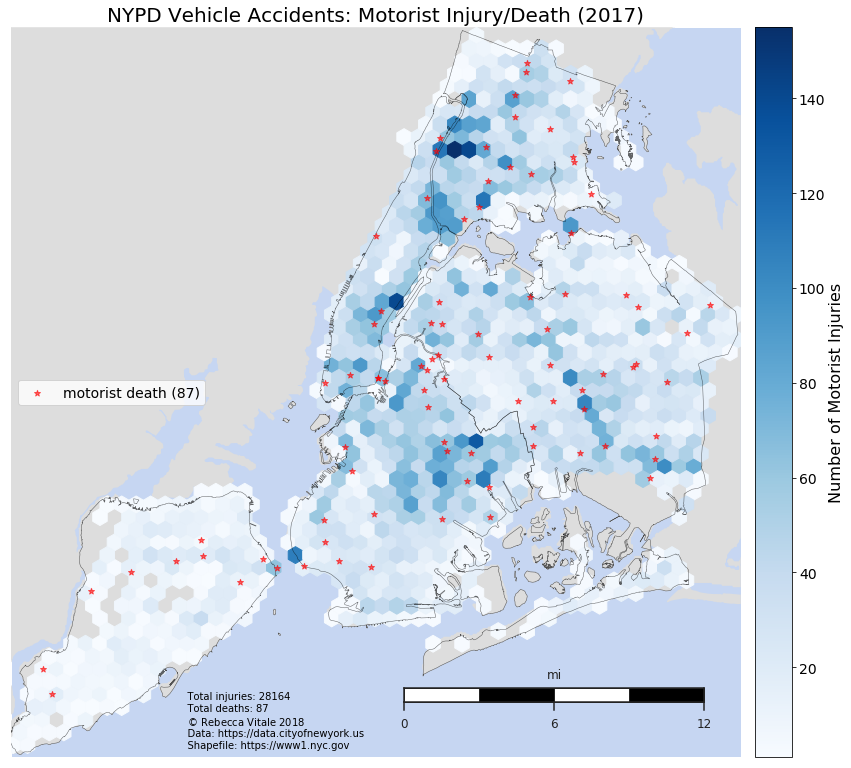

In [24]:
fig, ax = plt.subplots(figsize = (14, 14))
fig.patch.set_facecolor('white') ## so title background not transparent
plt.title('NYPD Vehicle Accidents: Motorist Injury/Death (2017)', fontsize = 20)

m = Basemap(
    height = 4.7E4,
    width = 4.7E4,
    resolution = 'f',
    projection = 'aea',
    lat_1 = acc['lat'].min(),
    lat_2 = acc['lat'].max(),
    lat_0 = (acc['lat'].min() + acc['lat'].max())/2.,
    lon_0 = (acc['lon'].min() + acc['lon'].max())/2.
)

water_color = '#c6d6f2'
m.fillcontinents(color = '#dddddd', lake_color = water_color, zorder = 2)
m.drawmapboundary(fill_color = water_color, color = 'white', zorder = 1)

m.readshapefile(
    'assets/nybb_18a/WGS84',
    'lil_place',
    drawbounds = True,
    color = '#cccccc',
    zorder = 3
)

m.scatter(
    motor.loc[motor['motorist killed'] != 0, 'lon'].values,
    motor.loc[motor['motorist killed'] != 0, 'lat'].values,
    latlon = True,
    zorder = 6,
    color = 'red',
    alpha = 0.6,
    s = 40,
    marker = '*',
    label = 'motorist death ({})'.format(len(motor[motor['motorist killed'] != 0]))
)

patches = []
for info, shape in zip(m.lil_place_info, m.lil_place):
    patches.append( polyg(np.array(shape), True) )

ax.add_collection(
    PatchCollection(
        patches,
        facecolor = '#dddddd',
        zorder = 4
    )
)

## convert latlon to basemap coords
motor['bm_coord'] = [m(x, y) for x, y in zip(motor['lon'], motor['lat'])]

m.hexbin(
    x = motor.loc[motor['motorist injured'] != 0, 'bm_coord'].apply(lambda x: x[0]),
    y = motor.loc[motor['motorist injured'] != 0, 'bm_coord'].apply(lambda x: x[1]),
#     C = C,
    gridsize = 50,
    mincnt = 1,
    cmap = 'Blues',
#     reduce_C_function = reduce_C_function,
#     norm = norm,
    zorder = 5
)

for info, shape in zip(m.lil_place_info, m.lil_place):
    x, y = zip(*shape)
    m.plot(
        x,
        y,
        color = 'k',
        alpha = 0.6,
        zorder = 5,
        linewidth = 0.5
    )

cb = m.colorbar(location = 'right', format = '%d')
cb.set_label(label = 'Number of Motorist Injuries', fontsize = 16)
cb.ax.tick_params(labelsize = 14)
# cb.set_ticks([0, 50, 150, 200])
# cb.set_ticklabels([1, 5, 10, 15, 20, 25, 30])

total_area = sum([Polygon(xy).area/1000000 for xy in m.lil_place])

smallprint = ax.text(
    0.225,
    0.01,
    '\
    Total injuries: {}\n\
    Total deaths: {}\n\
    $\copyright$ Rebecca Vitale 2018\n\
    Data: https://data.cityofnewyork.us\n\
    Shapefile: https://www1.nyc.gov'.format(
        len(motor[motor['motorist injured'] != 0]), 
        len(motor[motor['motorist killed'] != 0])),
    ha = 'left',
    va = 'bottom',
    size = 10,
    color = 'k',
    transform = ax.transAxes,
    zorder = 6
)

scale_coord = (35000, 4000)
scale_where = m(scale_coord[0], scale_coord[1], inverse = True)
m.drawmapscale(
    scale_where[0],
    scale_where[1],
    scale_where[0],
    scale_where[1],
    12,
    fontsize = 12,
    barstyle = 'fancy',
    zorder = 6,
    fontcolor = '#222222',
    units = 'mi'
)

plt.legend(loc = 'center left', fontsize = 14)
plt.show();

In [25]:
factor_counts = []
for i in range(1, 6):
    factor_counts.extend(acc['factor {}'.format(i)])
factor_counts = pd.DataFrame(factor_counts)[0].value_counts()
print(len(factor_counts))
factor_counts.head()

48


Unspecified                       222369
Driver Inattention/Distraction     64576
Following Too Closely              25541
Failure to Yield Right-of-Way      17530
Passing or Lane Usage Improper     12904
Name: 0, dtype: int64

In [26]:
factor = []
for i in range(len(acc)):
    lil_factor = []
    for i in range(1, 6):
        factorlet = acc.loc[i, 'factor {}'.format(i)]
        if type(factorlet) == str:
            lil_factor.append(factorlet.lower())
        else:
            pass
    factor.append(lil_factor)
for i in range(1, 6):
    acc.drop(['factor {}'.format(i)], axis = 1, inplace = True)
acc['factors'] = factor
del factor
acc['factors'].head()

0    [failure to yield right-of-way]
1    [failure to yield right-of-way]
2    [failure to yield right-of-way]
3    [failure to yield right-of-way]
4    [failure to yield right-of-way]
Name: factors, dtype: object

In [27]:
type_counts = []
for i in range(1, 6):
    type_counts.extend(acc['type {}'.format(i)])
type_counts = pd.DataFrame(type_counts)[0].value_counts()
print(len(type_counts))
type_counts.head()

260


PASSENGER VEHICLE                201238
SPORT UTILITY / STATION WAGON    139465
TAXI                              18657
PICK-UP TRUCK                     13107
BICYCLE                            6193
Name: 0, dtype: int64

In [28]:
types = []
for i in range(len(acc)):
    lil_type = []
    for i in range(1, 6):
        typelet = acc.loc[i, 'type {}'.format(i)]
        if type(typelet) == str:
            lil_type.append(typelet.lower())
        else:
            pass
    types.append(lil_type)
for i in range(1, 6):
    acc.drop(['type {}'.format(i)], axis = 1, inplace = True)
acc['types'] = types
del types
acc['types'].head()

0    [taxi, passenger vehicle]
1    [taxi, passenger vehicle]
2    [taxi, passenger vehicle]
3    [taxi, passenger vehicle]
4    [taxi, passenger vehicle]
Name: types, dtype: object

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Will come back and do more with these columns.